# <center>Stock Price Analysis (AAPL - Apple Inc.) </center> 
#  <center> Time Series Forecasting with SARIMA and Prophet</center> 
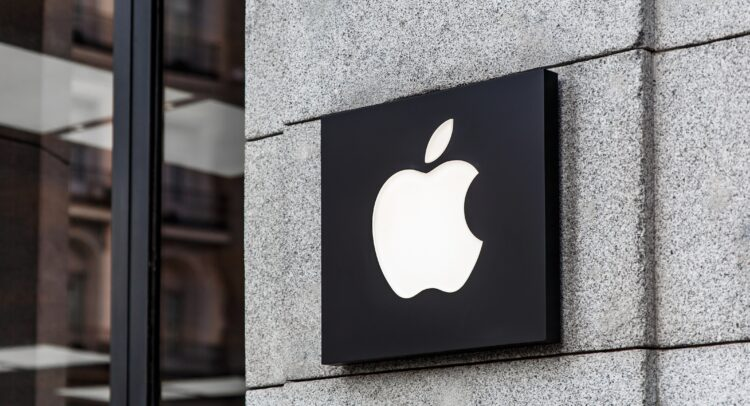

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA/SARIMA models to predict future close prices.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [2]:
# Downloading stock data for AAPL (Apple Inc.) over the past 5 years
# You can replace the ticker "AAPL" with another ticker symbol (e.g., "GOOGL" for Alphabet)
# Find the list of stocks here : https://finance.yahoo.com/markets/stocks/most-active/
end = pd.to_datetime("today").date()
start = end - pd.DateOffset(years=5)
df = yf.download("AAPL", start=start, end=end)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-01-19,124.436394,125.293036,123.570022,124.387718,90757300
2021-01-20,128.524918,128.972712,125.137307,125.244388,104319500
2021-01-21,133.236420,135.962089,130.043497,130.247929,120150900
2021-01-22,135.378021,136.137313,131.435536,132.662081,114459400
2021-01-25,139.125824,141.238214,132.915193,139.271851,157611700


In [3]:
df.shape

(1255, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2021-01-19 to 2026-01-15
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1255 non-null   float64
 1   (High, AAPL)    1255 non-null   float64
 2   (Low, AAPL)     1255 non-null   float64
 3   (Open, AAPL)    1255 non-null   float64
 4   (Volume, AAPL)  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB


## Data visualization

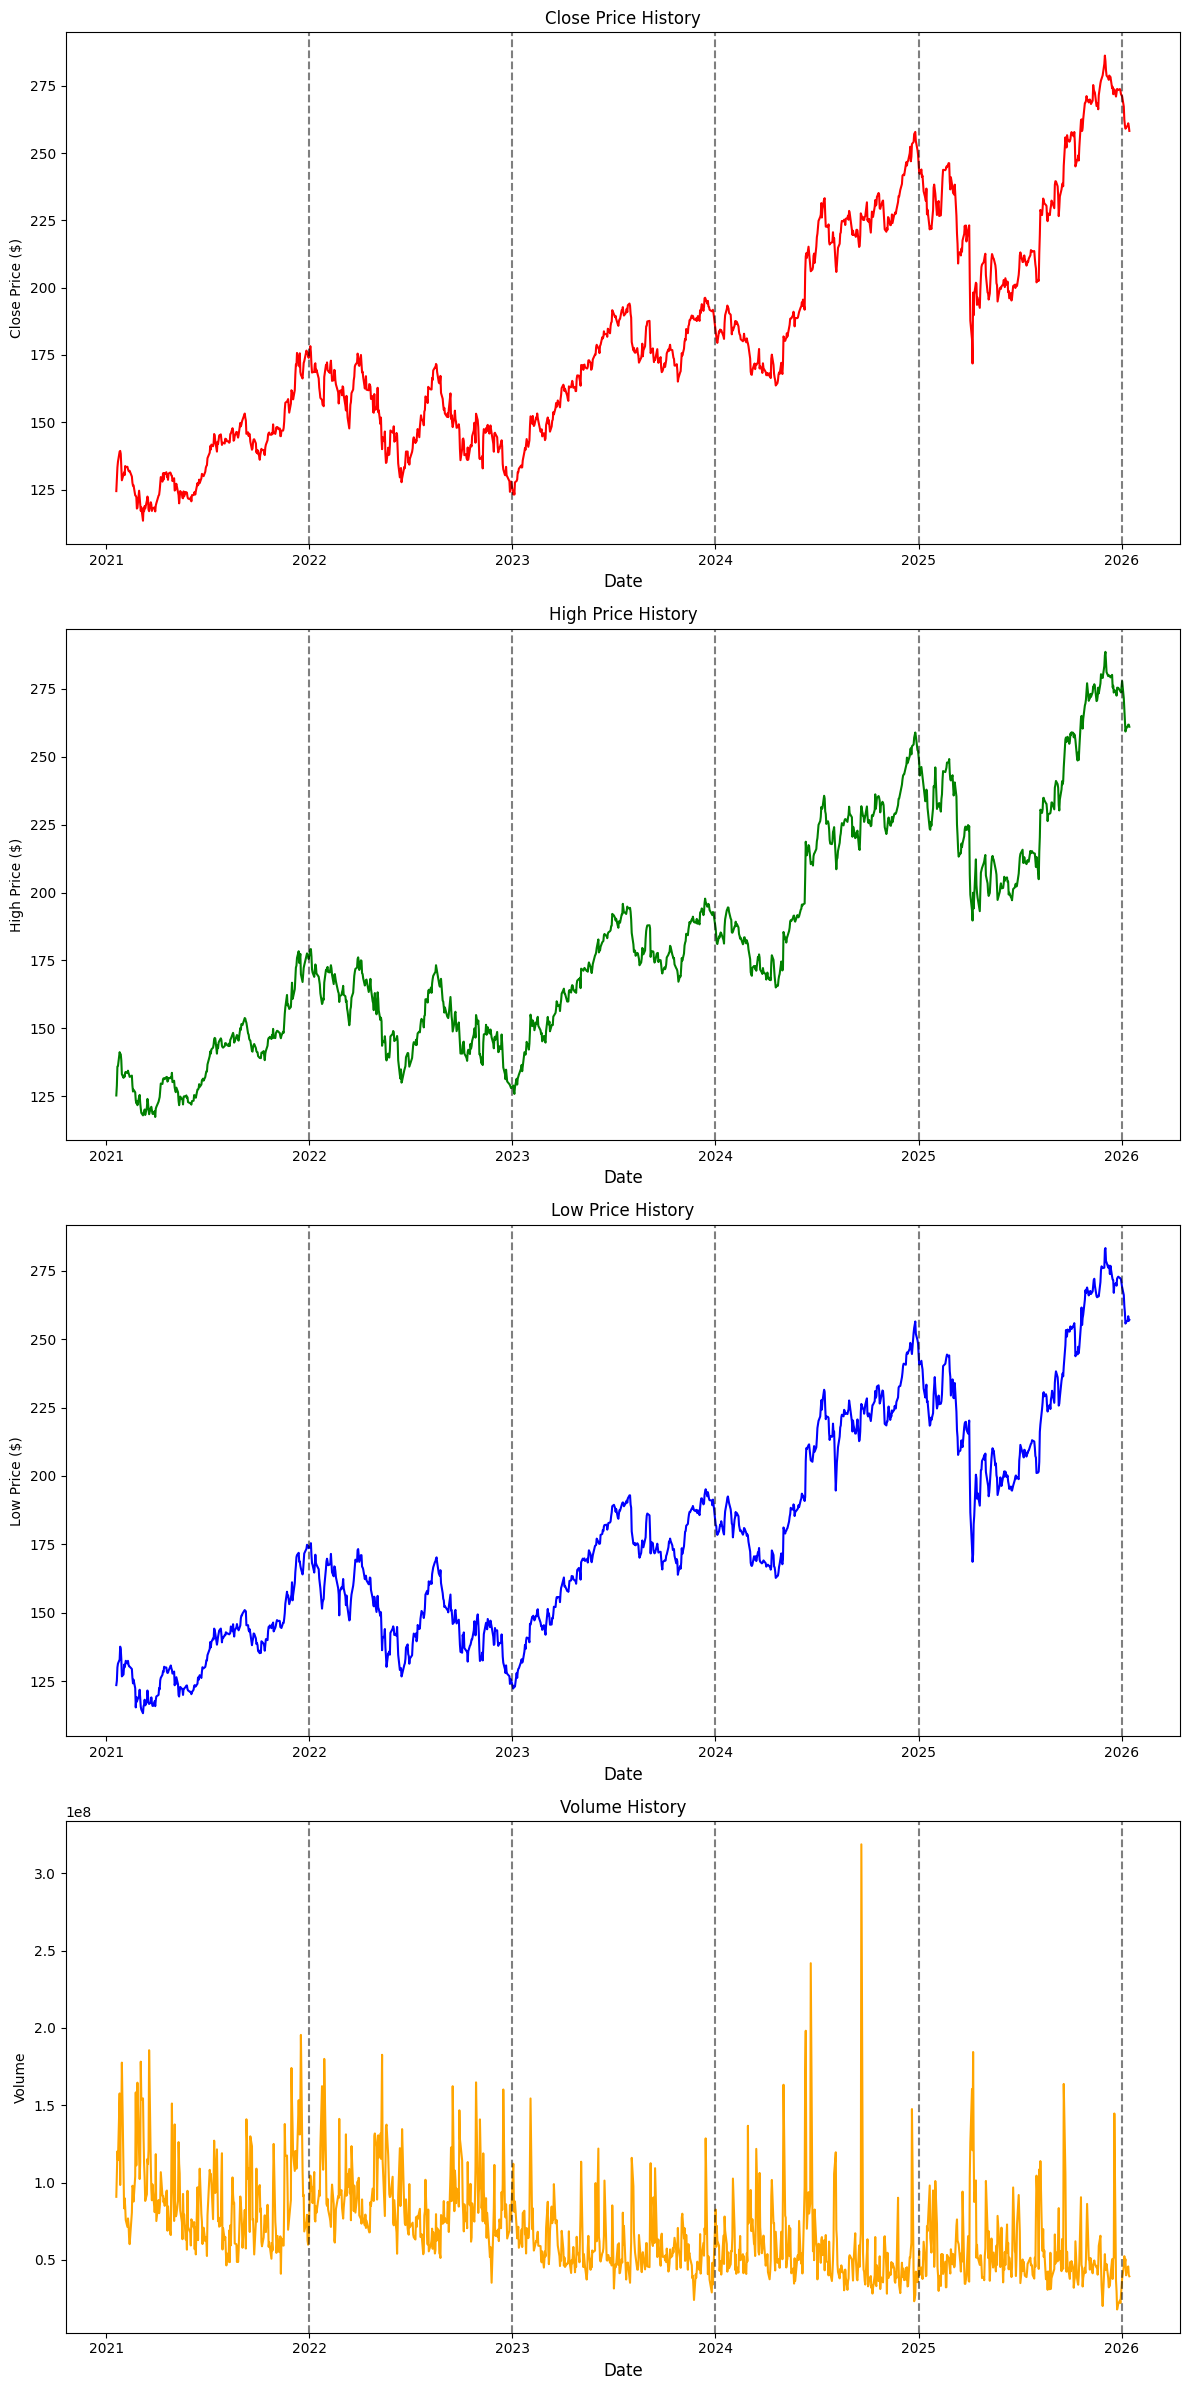

In [5]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price ($)")
ax1.set_title("Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("High Price ($)")
ax2.set_title("High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Low Price ($)")
ax3.set_title("Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

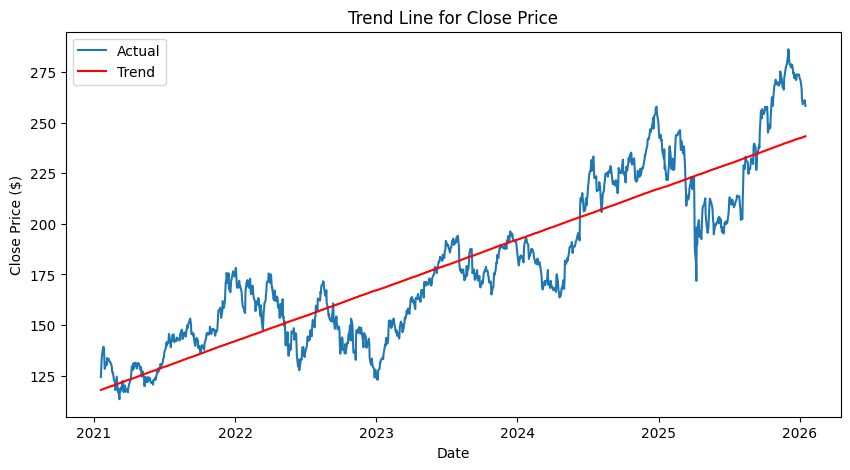

In [6]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [7]:
df2 = df[['Close']]
df2.head()

Price,Close
Ticker,AAPL
Date,
2021-01-19,124.436394
2021-01-20,128.524918
2021-01-21,133.236420
2021-01-22,135.378021
2021-01-25,139.125824


## Time decomposition

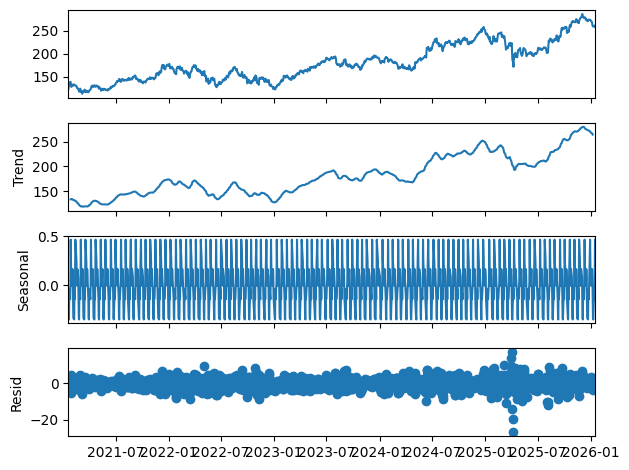

In [8]:
results = seasonal_decompose(df2['Close'], model='additive', period=12)
results.plot()
plt.show()

## Check stationarity

In [9]:
df_diff = df2.dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                             |
|---------------|-----------------------------------|
| ADF Statistic | -1.0591523201494755               |
| P-value       | 0.7310837041336531                |
| Conclusion    | The time series is not stationary |


In [10]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(df2,test = "adf")
print("d value:", d_value)

d value: 1


In [11]:
df_diff = df2.diff().dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                         |
|---------------|-------------------------------|
| ADF Statistic | -33.66555614445596            |
| P-value       | 0.0                           |
| Conclusion    | The time series is stationary |


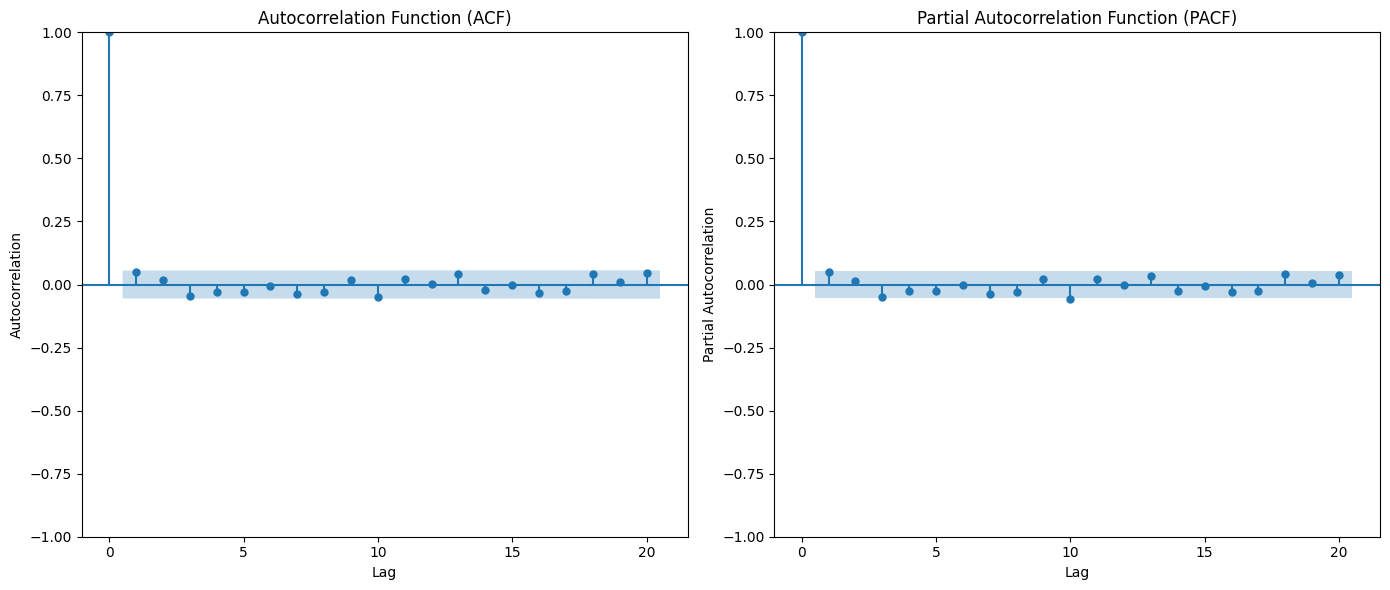

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns

# Plot ACF
plot_acf(df2.Close.diff().dropna(), lags=20, ax=ax[0])  # ACF on the left
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df2.Close.diff().dropna(), lags=20, ax=ax[1])  # PACF on the right
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Train / Test Split

In [13]:
split_index = int(len(df2) * 0.8)
df_train = df2.iloc[:split_index]
df_test = df2.iloc[split_index:]
print(len(df_train),len(df_test))

1004 251


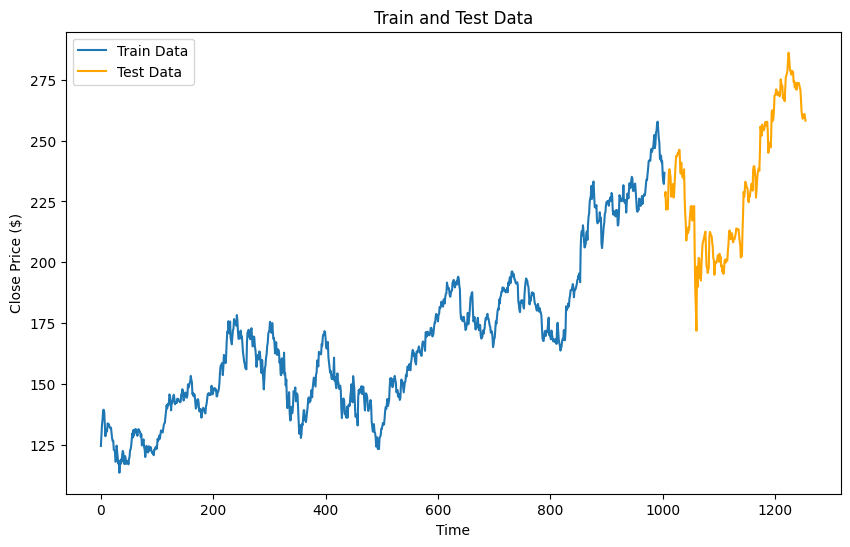

In [14]:
plt.figure(figsize=(10, 6))

# Plot x_train
plt.plot(range(len(df_train)), df_train, label='Train Data')

# Plot x_test
plt.plot(range(len(df_train), len(df_train) + len(df_test)), df_test, label='Test Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.title('Train and Test Data')
plt.legend()

plt.show()

## ARIMA

#### Define orders automatically

In [15]:
stepwise_fit = auto_arima(df2,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6382.596, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6380.259, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6379.138, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6379.247, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6379.767, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6380.867, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6381.049, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6381.876, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6378.503, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6380.193, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6380.399, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6378.624, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6381.198, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.644 seconds
                      

#### Plot residuals

(array([1.75725398e-03, 6.64461663e-02, 6.04056057e-04, 5.49141870e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.49141870e-05]),
 array([-20.66504405,  -6.15490027,   8.35524351,  22.86538729,
         37.37553107,  51.88567484,  66.39581862,  80.9059624 ,
         95.41610618, 109.92624996, 124.43639374]),
 <BarContainer object of 10 artists>)

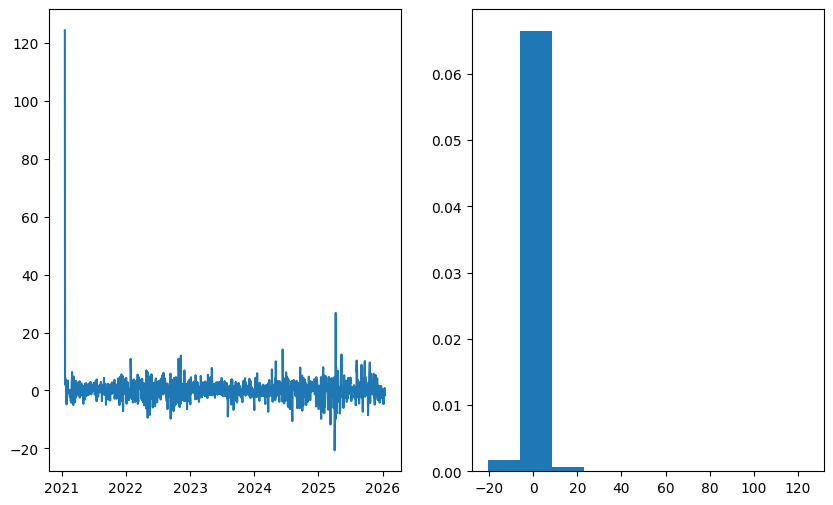

In [16]:
# Get the residuals from the fitted model
residuals = pd.DataFrame(stepwise_fit.arima_res_.resid, columns=['Residuals'])

# Create a subplot with 2 plots :  residuals over time and histogral of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot residuals over time to check for any patterns or trends
ax1.plot(residuals)
ax2.hist(residuals, density=True)

#### Make prediction

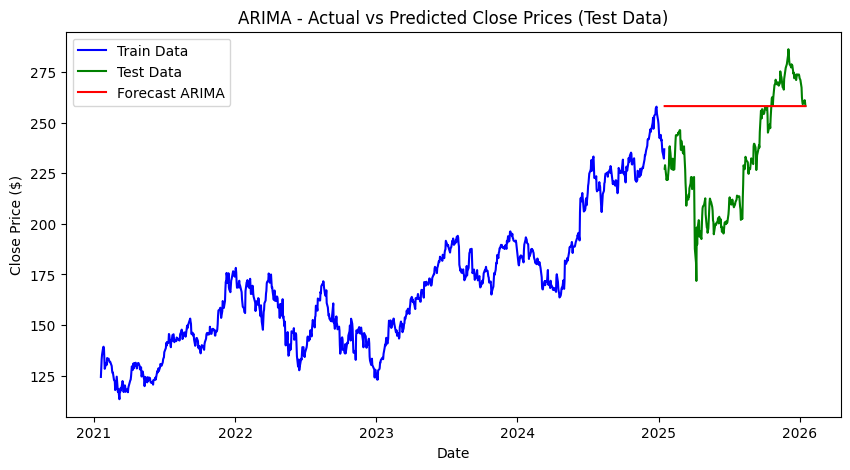

In [17]:
# Predict values for the test dataset
pred_arima = stepwise_fit.predict(n_periods=len(df_test))

df_fct = df2.copy()
df_fct['fct_arima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = pred_arima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')

plt.title('ARIMA - Actual vs Predicted Close Prices (Test Data)')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the ARIMA Model (rolling cross validation)

In [18]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_arima_list = []
mape_arima_list = []
rmse_arima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]

    # Make predictions on the test set
    predictions = stepwise_fit.predict(n_periods=len(test))

    # Calculate performance metrics
    mae_arima = mean_absolute_error(test, predictions)
    mape_arima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_arima = np.sqrt(mean_squared_error(test, predictions))

    # Append metrics to the respective lists
    mae_arima_list.append(mae_arima)
    mape_arima_list.append(mape_arima)
    rmse_arima_list.append(rmse_arima)

# Calculate average performance metrics across all folds
avg_mae_arima = np.mean(mae_arima_list)
avg_mape_arima = np.mean(mape_arima_list)
avg_rmse_arima = np.mean(rmse_arima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [avg_mae_arima, f'{avg_mape_arima:.2f}%', avg_rmse_arima]
})
print(performance.set_index('Metrics'))


             ARIMA
Metrics           
MAE      69.596245
MAPE        41.65%
RMSE     72.006546


## SARIMA

#### Define orders automatically

In [19]:
from pmdarima import auto_arima
smodel = auto_arima(
                    df2,
                    seasonal=True,
                    m=7,
                    max_p=7,
                    max_d=1,
                    max_q=3,
                    max_P=3,
                    max_D=1,
                    max_Q=2,
                    trace=True,
                    error_action='ignore',    # To print the progress of the fitting
                    suppress_warnings=True,   # Ignore potential errors
                    sn_jobs=-1)               # Use all available CPU cores
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=6377.797, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6380.259, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6379.635, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6379.667, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6379.767, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=6378.747, Time=0.49 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=6379.259, Time=0.37 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=6379.747, Time=1.37 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=6379.644, Time=1.41 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=6382.596, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=6377.877, Time=1.33 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=6378.130, Time=1.21 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=6381.750, Time=1.50 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=6383.407, Time=0.60 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1255
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3180.899
Date:                             Fri, 16 Jan 2026   AIC                           6377.797
Time:                                     17:35:55   BIC                           6418.870
Sample:                                          0   HQIC                          6393.235
                                            - 1255                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0483      0.044      1.090      0.276      -0.039       0.135
ar.L1          1.1686      0.012     94.093      0.000       1.144       1.193
ar.L2         -0.9855      0.013    -77.264      0.000      -1.010      -0.960
ma.L1         -1.1581      0.019    -62.341      0.000      -1.195      -1.122
ma.L2          0.9680      0.019     50.506      0.000       0.930       1.006
ar.S.L7        0.4493      0.310      1.448      0.148      -0.159       1.057
ma.S.L7       -0.5155      0.299     -1.725      0.084      -1.101       0.070
sigma2         9.3472      0.200     46.677      0.000       8.955       9.740
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):              2908.41
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot residuals

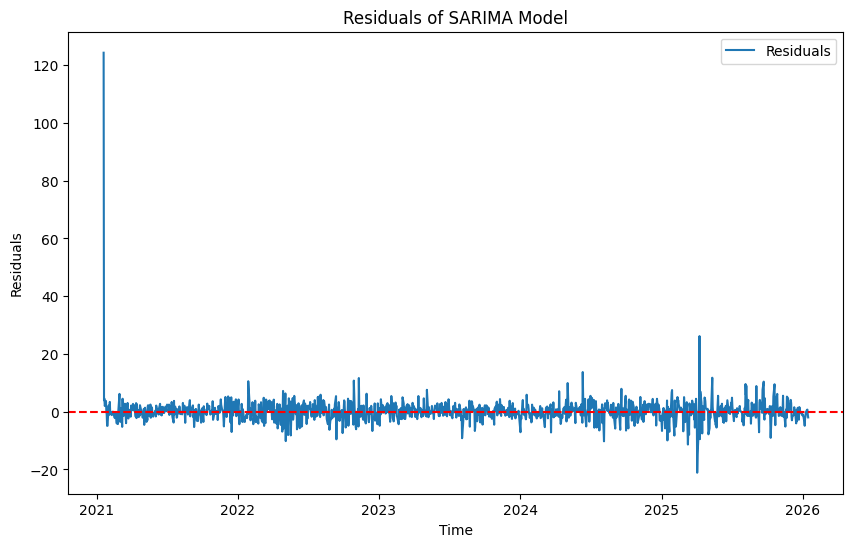

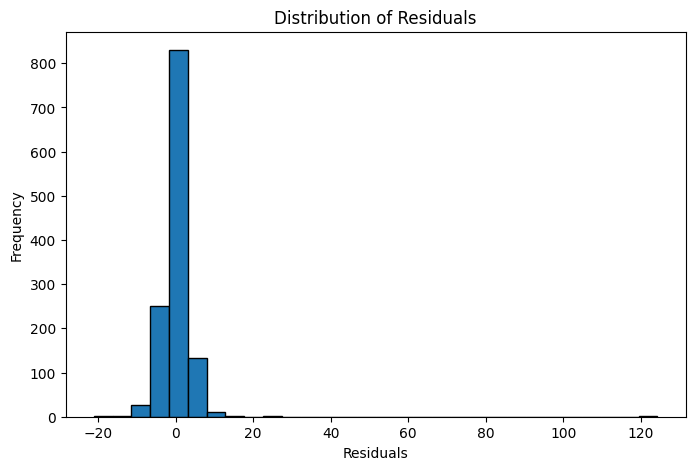

In [20]:
# Get the residuals from the fitted SARIMA model
residuals = smodel.resid()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Optional: Plot the histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


#### Make predictions

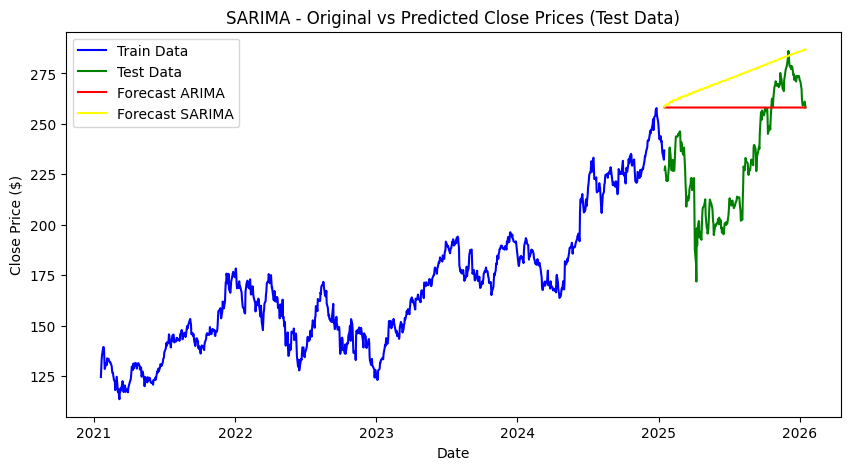

In [21]:
# Make predictions for the test dataset
predictions_sarima = smodel.predict(n_periods=len(df_test))

df_fct['fct_sarima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_sarima'] = predictions_sarima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='yellow')


plt.title('SARIMA - Original vs Predicted Close Prices (Test Data)')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the SARIMA Vs ARIMA (rolling cross validation)

In [22]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_sarima_list = []
mape_sarima_list = []
rmse_sarima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]

    # Make predictions on the test set
    predictions = smodel.predict(n_periods=len(test))

    # Calculate performance metrics
    mae_sarima = mean_absolute_error(test, predictions)
    mape_sarima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_sarima = np.sqrt(mean_squared_error(test, predictions))

    # Append metrics to the respective lists
    mae_sarima_list.append(mae_sarima)
    mape_sarima_list.append(mape_sarima)
    rmse_sarima_list.append(rmse_sarima)

# Calculate average performance metrics across all folds
avg_mae_sarima = np.mean(mae_sarima_list)
avg_mape_sarima = np.mean(mape_sarima_list)
avg_rmse_sarima = np.mean(rmse_sarima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [avg_mae_arima, f'{avg_mape_arima:.2f}%', avg_rmse_arima],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima]
})
print(performance.set_index('Metrics'))


             ARIMA     SARIMA
Metrics                      
MAE      69.596245  81.280115
MAPE        41.65%     48.17%
RMSE     72.006546  83.375318


Since both ARIMA and SARIMA give exactly the same performance metrics, it means that seasonality isn't playing a significant role in this particular dataset. 

## Prophet

In [25]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index()
# Flatten the MultiIndex columns
df_train_prophet.columns = df_train_prophet.columns.get_level_values(0)
df_train_prophet = df_train_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

df_test_prophet = df_test.reset_index()
# Flatten the MultiIndex columns
df_test_prophet.columns = df_test_prophet.columns.get_level_values(0)
df_test_prophet = df_test_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

df_train_prophet.head()

Price,ds,y
0,2021-01-19,124.436394
1,2021-01-20,128.524918
2,2021-01-21,133.236420
3,2021-01-22,135.378021
4,2021-01-25,139.125824


##### Fit

In [26]:
%%time
m_prophet = Prophet()
m_prophet.fit(df_train_prophet)

17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 31.2 ms
Wall time: 160 ms


##### Generate predictions

In [27]:
fct_prophet = m_prophet.predict(df_test_prophet)
fct_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-01-16,246.689654,237.255125,253.858370,246.689654,246.689654,-1.568580,-1.568580,-1.568580,0.337798,0.337798,0.337798,-1.906378,-1.906378,-1.906378,0.0,0.0,0.0,245.121073
1,2025-01-17,246.908996,237.407124,254.453476,246.908996,246.908996,-1.202691,-1.202691,-1.202691,0.522609,0.522609,0.522609,-1.725300,-1.725300,-1.725300,0.0,0.0,0.0,245.706305
2,2025-01-21,247.786365,238.818613,256.051502,247.786365,247.786365,-0.046276,-0.046276,-0.046276,0.508042,0.508042,0.508042,-0.554318,-0.554318,-0.554318,0.0,0.0,0.0,247.740089
3,2025-01-22,248.005707,239.509206,256.772088,248.005707,248.005707,0.186354,0.186354,0.186354,0.359127,0.359127,0.359127,-0.172773,-0.172773,-0.172773,0.0,0.0,0.0,248.192060
4,2025-01-23,248.225049,240.197168,257.791672,248.225049,248.225049,0.570863,0.570863,0.570863,0.337798,0.337798,0.337798,0.233065,0.233065,0.233065,0.0,0.0,0.0,248.795912


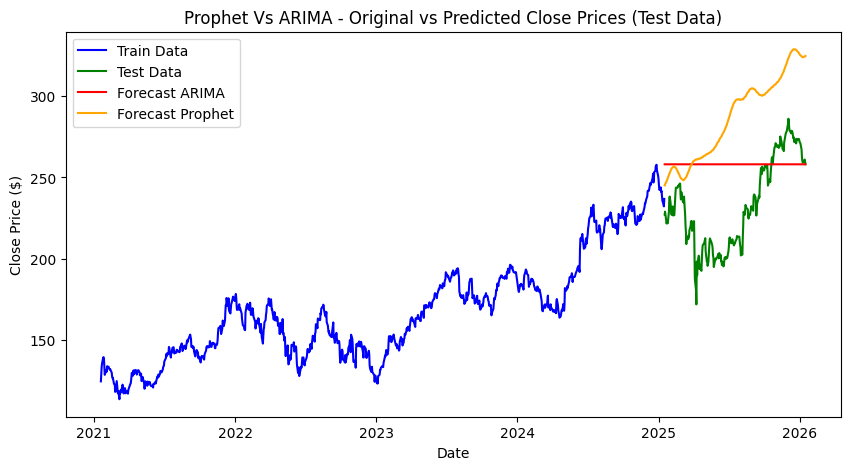

In [28]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Prophet Vs ARIMA - Original vs Predicted Close Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

#### Evaluate the prophet model (cross validation)

In [29]:
df_prophet = df.reset_index()
# Flatten the MultiIndex columns
df_prophet.columns = df_prophet.columns.get_level_values(0)
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

Price,ds,y,High,Low,Open,Volume
0,2021-01-19,124.436394,125.293036,123.570022,124.387718,90757300
1,2021-01-20,128.524918,128.972712,125.137307,125.244388,104319500
2,2021-01-21,133.236420,135.962089,130.043497,130.247929,120150900
3,2021-01-22,135.378021,136.137313,131.435536,132.662081,114459400
4,2021-01-25,139.125824,141.238214,132.915193,139.271851,157611700


In [30]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-27,128.889049,122.666406,135.240329,143.761154,2023-01-26
1,2023-01-30,128.732000,122.493491,134.995277,140.874725,2023-01-26
2,2023-01-31,128.506800,122.026796,134.865893,142.145538,2023-01-26
3,2023-02-01,128.420302,121.889948,135.164603,143.268585,2023-01-26
4,2023-02-02,127.890360,121.382799,134.416418,148.578506,2023-01-26


## Comparison of metrics - ARIMA vs Prophet models

In [31]:
mae_prophet = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [avg_mae_arima, f'{avg_mape_arima:.2f}%', avg_rmse_arima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

             ARIMA    Prophet
Metrics                      
MAE      69.596245  53.731419
MAPE        41.65%     27.69%
RMSE     72.006546  64.746261


#### ✨ The more effective model is the one with the lower MAPE : Prophet ✨

## 2-Year forecast using the best model

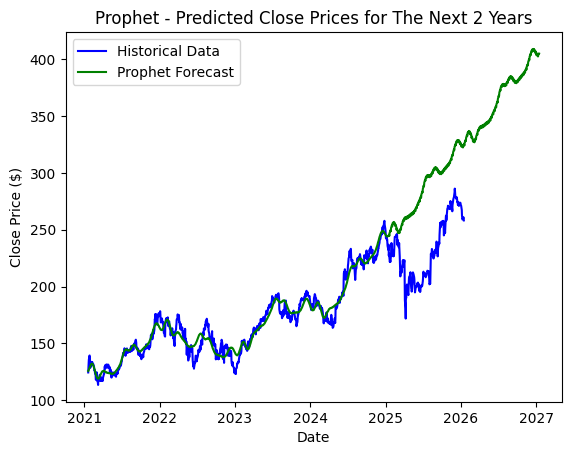

In [32]:
year = 2
steps = year * 365   # Number of steps to forecast (daily data)
df = df.reset_index() # Reset index

# Create future dataframe and predict
future_prophet = m_prophet.make_future_dataframe(periods=steps, freq='D')
prophet_forecast = m_prophet.predict(future_prophet)

# Plot
plt.plot(df2.index, df2['Close'], label='Historical Data', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='green')

plt.title(f"Prophet - Predicted Close Prices for The Next {year} Years")
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()